# Motivation : 
I read an interesting article about anomaly detection: https://iwringer.wordpress.com/2015/11/17/anomaly-detection-concepts-and-techniques/.  
I wanted to try a few of these techniques to better understand them. I searched an interesting dataset on Kaggle about anomaly detection with simple exemples. I choose one exemple of NAB datasets (thanks for this datasets) and I implemented a few of these algorithms. The goal of this Notebook is just to implement these techniques and understand there main caracteristics. Sometimes, they are not adapted to this datasets. I add some visualizations to understand what the algorithm detect. Hope it can help some people.
Notebook available (with Markov Chain) here: https://github.com/Vicam/Unsupervised_Anomaly_Detection

# Algorithm implemented :
- Cluster based anomaly detection (K-mean)
- Repartition of data into categories then Gaussian/Elliptic Enveloppe on each categories separately
- Markov Chain
- Isolation Forest
- One class SVM
- RNN (comparison between prediction and reality)

In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'
import warnings
warnings.filterwarnings('ignore')

In [2]:
# libraries
#%matplotlib notebook

import pandas as pd
import numpy as np

import matplotlib
import seaborn
import matplotlib.dates as md
from matplotlib import pyplot as plt

from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.covariance import EllipticEnvelope
#from pyemma import msm # not available on Kaggle Kernel
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM

In [23]:
# some function for later

# return Series of distance between each point and his distance with the closest centroid
def getDistanceByPoint(data, model):
    distance = pd.Series()
    for i in range(0,len(data)):
        Xa = np.array(data.loc[i])
        Xb = model.cluster_centers_[model.labels_[i]-1]
        distance.set_value(i, np.linalg.norm(Xa-Xb))
    return distance

# train markov model to get transition matrix
def getTransitionMatrix (df):
    df = np.array(df)
    model = msm.estimate_markov_model(df, 1)
    return model.transition_matrix

def markovAnomaly(df, windows_size, threshold):
    transition_matrix = getTransitionMatrix(df)
    real_threshold = threshold**windows_size
    df_anomaly = []
    for j in range(0, len(df)):
        if (j < windows_size):
            df_anomaly.append(0)
        else:
            sequence = df[j-windows_size:j]
            sequence = sequence.reset_index(drop=True)
            df_anomaly.append(anomalyElement(sequence, real_threshold, transition_matrix))
    return df_anomaly

# 1 Data
## 1.1 Extract data
The dataset is from https://www.kaggle.com/boltzmannbrain/nab 
In realKnownCause/ambient_temperature_system_failure.csv

In [4]:
df = pd.read_csv("./data/ambient_temperature_system_failure.csv")
df

,timestamp,value
0,2013-07-04 00:00:00,69.880835
1,2013-07-04 01:00:00,71.220227
2,2013-07-04 02:00:00,70.877805
3,2013-07-04 03:00:00,68.959400
4,2013-07-04 04:00:00,69.283551
...,...,...
7262,2014-05-28 11:00:00,72.370206
7263,2014-05-28 12:00:00,72.172956
7264,2014-05-28 13:00:00,72.046565
7265,2014-05-28 14:00:00,71.825226


## 1.2 Understand data

In [5]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7267 entries, 0 to 7266
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   timestamp  7267 non-null   object 
 1   value      7267 non-null   float64
dtypes: float64(1), object(1)
memory usage: 113.7+ KB
None


In [6]:
# check the timestamp format and frequence 
print(df['timestamp'].head(10))

0    2013-07-04 00:00:00
1    2013-07-04 01:00:00
2    2013-07-04 02:00:00
3    2013-07-04 03:00:00
4    2013-07-04 04:00:00
5    2013-07-04 05:00:00
6    2013-07-04 06:00:00
7    2013-07-04 07:00:00
8    2013-07-04 08:00:00
9    2013-07-04 09:00:00
Name: timestamp, dtype: object


In [7]:
# check the temperature mean
print(df['value'].mean())

71.2424327082882


<AxesSubplot:xlabel='timestamp'>

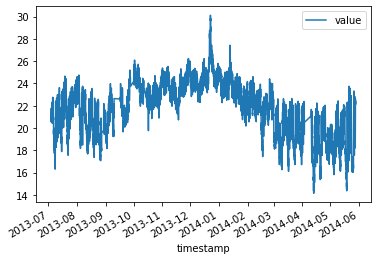

In [8]:
# change the type of timestamp column for plotting
df['timestamp'] = pd.to_datetime(df['timestamp'])
# change fahrenheit to °C (temperature mean= 71 -> fahrenheit)
df['value'] = (df['value'] - 32) * 5/9
# plot the data
df.plot(x='timestamp', y='value')

## 1.3 Feature engineering
Extracting some useful features

In [9]:
# the hours and if it's night or day (7:00-22:00)
df['hours'] = df['timestamp'].dt.hour
df['daylight'] = ((df['hours'] >= 7) & (df['hours'] <= 22)).astype(int)

In [10]:
# the day of the week (Monday=0, Sunday=6) and if it's a week end day or week day.
df['DayOfTheWeek'] = df['timestamp'].dt.dayofweek
df['WeekDay'] = (df['DayOfTheWeek'] < 5).astype(int)
# An estimation of anomly population of the dataset (necessary for several algorithm)
outliers_fraction = 0.01

In [11]:
# time with int to plot easily
df['time_epoch'] = (df['timestamp'].astype(np.int64)/100000000000).astype(np.int64)

<BarContainer object of 10 artists>

<BarContainer object of 10 artists>

<BarContainer object of 10 artists>

<BarContainer object of 10 artists>

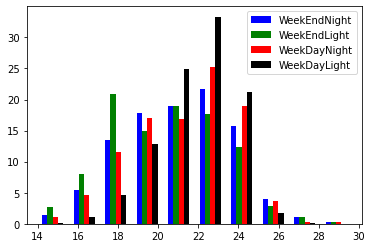

In [12]:
# creation of 4 distinct categories that seem useful (week end/day week & night/day)
df['categories'] = df['WeekDay']*2 + df['daylight']

a = df.loc[df['categories'] == 0, 'value']
b = df.loc[df['categories'] == 1, 'value']
c = df.loc[df['categories'] == 2, 'value']
d = df.loc[df['categories'] == 3, 'value']

fig, ax = plt.subplots()
a_heights, a_bins = np.histogram(a)
b_heights, b_bins = np.histogram(b, bins=a_bins)
c_heights, c_bins = np.histogram(c, bins=a_bins)
d_heights, d_bins = np.histogram(d, bins=a_bins)

width = (a_bins[1] - a_bins[0])/6

ax.bar(a_bins[:-1], a_heights*100/a.count(), width=width, facecolor='blue', label='WeekEndNight')
ax.bar(b_bins[:-1]+width, (b_heights*100/b.count()), width=width, facecolor='green', label ='WeekEndLight')
ax.bar(c_bins[:-1]+width*2, (c_heights*100/c.count()), width=width, facecolor='red', label ='WeekDayNight')
ax.bar(d_bins[:-1]+width*3, (d_heights*100/d.count()), width=width, facecolor='black', label ='WeekDayLight')

plt.legend()
plt.show()

We can see that the temperature is more stable during daylight of business day.
# 2 Models
## 2.1 Cluster only
#### Use for collective anomalies (unordered). 

We group together the usual combination of features. The points that are far from the cluster are points with usual combination of features.We consider those points as anomalies.

In [13]:
df

,timestamp,value,hours,daylight,DayOfTheWeek,WeekDay,time_epoch,categories
0,2013-07-04 00:00:00,21.044908,0,0,3,1,13728960,2
1,2013-07-04 01:00:00,21.789015,1,0,3,1,13728996,2
2,2013-07-04 02:00:00,21.598781,2,0,3,1,13729032,2
3,2013-07-04 03:00:00,20.533000,3,0,3,1,13729068,2
4,2013-07-04 04:00:00,20.713084,4,0,3,1,13729104,2
...,...,...,...,...,...,...,...,...
7262,2014-05-28 11:00:00,22.427892,11,1,2,1,14012748,3
7263,2014-05-28 12:00:00,22.318309,12,1,2,1,14012784,3
7264,2014-05-28 13:00:00,22.248092,13,1,2,1,14012820,3
7265,2014-05-28 14:00:00,22.125126,14,1,2,1,14012856,3


In [14]:
# Take useful feature and standardize them
data = df[['value', 'hours', 'daylight', 'DayOfTheWeek', 'WeekDay']]
min_max_scaler = preprocessing.StandardScaler()
np_scaled = min_max_scaler.fit_transform(data)
data = pd.DataFrame(np_scaled)
# reduce to 2 importants features
pca = PCA(n_components=2)
data = pca.fit_transform(data)
# standardize these 2 new features
min_max_scaler = preprocessing.StandardScaler()
np_scaled = min_max_scaler.fit_transform(data)
data = pd.DataFrame(np_scaled)

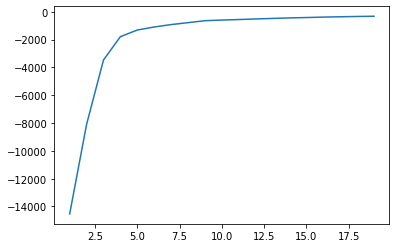

In [15]:
# calculate with different number of centroids to see the loss plot (elbow method)
n_cluster = range(1, 20)
kmeans = [KMeans(n_clusters=i).fit(data) for i in n_cluster]
scores = [kmeans[i].score(data) for i in range(len(kmeans))]
fig, ax = plt.subplots()
ax.plot(n_cluster, scores)
plt.show()

In [16]:
# Not clear for me, I choose 15 centroids arbitrarily and add these data to the central dataframe
df['cluster'] = kmeans[14].predict(data)
df['principal_feature1'] = data[0]
df['principal_feature2'] = data[1]
df['cluster'].value_counts()

0     603
3     596
1     590
13    582
12    577
4     576
10    526
5     517
7     494
14    428
6     403
9     350
11    345
2     342
8     338
Name: cluster, dtype: int64

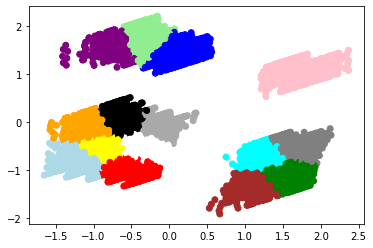

In [17]:
#plot the different clusters with the 2 main features
fig, ax = plt.subplots()
colors = {0:'red', 1:'blue', 2:'green', 3:'pink', 4:'black', 5:'orange', 6:'cyan', 7:'yellow', 8:'brown', 9:'purple', 10:'white', 11: 'grey', 12:'lightblue', 13:'lightgreen', 14: 'darkgrey'}
ax.scatter(df['principal_feature1'], df['principal_feature2'], c=df["cluster"].apply(lambda x: colors[x]))
plt.show()

In [18]:
data

,0,1
0,0.066191,1.755363
1,-0.009413,1.647609
2,-0.009359,1.577677
3,0.061592,1.543184
4,0.031660,1.458262
...,...,...
7262,-0.663130,-0.218870
7263,-0.669607,-0.292067
7264,-0.679271,-0.366858
7265,-0.684664,-0.439514


In [28]:
data.shape

(7267, 2)

In [27]:
for i in range(0, len(data)):
    i

0

1

2

3

4

5

6

7

8

9

10

11

12

13

14

15

16

17

18

19

20

21

22

23

24

25

26

27

28

29

30

31

32

33

34

35

36

37

38

39

40

41

42

43

44

45

46

47

48

49

50

51

52

53

54

55

56

57

58

59

60

61

62

63

64

65

66

67

68

69

70

71

72

73

74

75

76

77

78

79

80

81

82

83

84

85

86

87

88

89

90

91

92

93

94

95

96

97

98

99

100

101

102

103

104

105

106

107

108

109

110

111

112

113

114

115

116

117

118

119

120

121

122

123

124

125

126

127

128

129

130

131

132

133

134

135

136

137

138

139

140

141

142

143

144

145

146

147

148

149

150

151

152

153

154

155

156

157

158

159

160

161

162

163

164

165

166

167

168

169

170

171

172

173

174

175

176

177

178

179

180

181

182

183

184

185

186

187

188

189

190

191

192

193

194

195

196

197

198

199

200

201

202

203

204

205

206

207

208

209

210

211

212

213

214

215

216

217

218

219

220

221

222

223

224

225

226

227

228

229

230

231

232

233

234

235

236

237

238

239

240

241

242

243

244

245

246

247

248

249

250

251

252

253

254

255

256

257

258

259

260

261

262

263

264

265

266

267

268

269

270

271

272

273

274

275

276

277

278

279

280

281

282

283

284

285

286

287

288

289

290

291

292

293

294

295

296

297

298

299

300

301

302

303

304

305

306

307

308

309

310

311

312

313

314

315

316

317

318

319

320

321

322

323

324

325

326

327

328

329

330

331

332

333

334

335

336

337

338

339

340

341

342

343

344

345

346

347

348

349

350

351

352

353

354

355

356

357

358

359

360

361

362

363

364

365

366

367

368

369

370

371

372

373

374

375

376

377

378

379

380

381

382

383

384

385

386

387

388

389

390

391

392

393

394

395

396

397

398

399

400

401

402

403

404

405

406

407

408

409

410

411

412

413

414

415

416

417

418

419

420

421

422

423

424

425

426

427

428

429

430

431

432

433

434

435

436

437

438

439

440

441

442

443

444

445

446

447

448

449

450

451

452

453

454

455

456

457

458

459

460

461

462

463

464

465

466

467

468

469

470

471

472

473

474

475

476

477

478

479

480

481

482

483

484

485

486

487

488

489

490

491

492

493

494

495

496

497

498

499

500

501

502

503

504

505

506

507

508

509

510

511

512

513

514

515

516

517

518

519

520

521

522

523

524

525

526

527

528

529

530

531

532

533

534

535

536

537

538

539

540

541

542

543

544

545

546

547

548

549

550

551

552

553

554

555

556

557

558

559

560

561

562

563

564

565

566

567

568

569

570

571

572

573

574

575

576

577

578

579

580

581

582

583

584

585

586

587

588

589

590

591

592

593

594

595

596

597

598

599

600

601

602

603

604

605

606

607

608

609

610

611

612

613

614

615

616

617

618

619

620

621

622

623

624

625

626

627

628

629

630

631

632

633

634

635

636

637

638

639

640

641

642

643

644

645

646

647

648

649

650

651

652

653

654

655

656

657

658

659

660

661

662

663

664

665

666

667

668

669

670

671

672

673

674

675

676

677

678

679

680

681

682

683

684

685

686

687

688

689

690

691

692

693

694

695

696

697

698

699

700

701

702

703

704

705

706

707

708

709

710

711

712

713

714

715

716

717

718

719

720

721

722

723

724

725

726

727

728

729

730

731

732

733

734

735

736

737

738

739

740

741

742

743

744

745

746

747

748

749

750

751

752

753

754

755

756

757

758

759

760

761

762

763

764

765

766

767

768

769

770

771

772

773

774

775

776

777

778

779

780

781

782

783

784

785

786

787

788

789

790

791

792

793

794

795

796

797

798

799

800

801

802

803

804

805

806

807

808

809

810

811

812

813

814

815

816

817

818

819

820

821

822

823

824

825

826

827

828

829

830

831

832

833

834

835

836

837

838

839

840

841

842

843

844

845

846

847

848

849

850

851

852

853

854

855

856

857

858

859

860

861

862

863

864

865

866

867

868

869

870

871

872

873

874

875

876

877

878

879

880

881

882

883

884

885

886

887

888

889

890

891

892

893

894

895

896

897

898

899

900

901

902

903

904

905

906

907

908

909

910

911

912

913

914

915

916

917

918

919

920

921

922

923

924

925

926

927

928

929

930

931

932

933

934

935

936

937

938

939

940

941

942

943

944

945

946

947

948

949

950

951

952

953

954

955

956

957

958

959

960

961

962

963

964

965

966

967

968

969

970

971

972

973

974

975

976

977

978

979

980

981

982

983

984

985

986

987

988

989

990

991

992

993

994

995

996

997

998

999

1000

1001

1002

1003

1004

1005

1006

1007

1008

1009

1010

1011

1012

1013

1014

1015

1016

1017

1018

1019

1020

1021

1022

1023

1024

1025

1026

1027

1028

1029

1030

1031

1032

1033

1034

1035

1036

1037

1038

1039

1040

1041

1042

1043

1044

1045

1046

1047

1048

1049

1050

1051

1052

1053

1054

1055

1056

1057

1058

1059

1060

1061

1062

1063

1064

1065

1066

1067

1068

1069

1070

1071

1072

1073

1074

1075

1076

1077

1078

1079

1080

1081

1082

1083

1084

1085

1086

1087

1088

1089

1090

1091

1092

1093

1094

1095

1096

1097

1098

1099

1100

1101

1102

1103

1104

1105

1106

1107

1108

1109

1110

1111

1112

1113

1114

1115

1116

1117

1118

1119

1120

1121

1122

1123

1124

1125

1126

1127

1128

1129

1130

1131

1132

1133

1134

1135

1136

1137

1138

1139

1140

1141

1142

1143

1144

1145

1146

1147

1148

1149

1150

1151

1152

1153

1154

1155

1156

1157

1158

1159

1160

1161

1162

1163

1164

1165

1166

1167

1168

1169

1170

1171

1172

1173

1174

1175

1176

1177

1178

1179

1180

1181

1182

1183

1184

1185

1186

1187

1188

1189

1190

1191

1192

1193

1194

1195

1196

1197

1198

1199

1200

1201

1202

1203

1204

1205

1206

1207

1208

1209

1210

1211

1212

1213

1214

1215

1216

1217

1218

1219

1220

1221

1222

1223

1224

1225

1226

1227

1228

1229

1230

1231

1232

1233

1234

1235

1236

1237

1238

1239

1240

1241

1242

1243

1244

1245

1246

1247

1248

1249

1250

1251

1252

1253

1254

1255

1256

1257

1258

1259

1260

1261

1262

1263

1264

1265

1266

1267

1268

1269

1270

1271

1272

1273

1274

1275

1276

1277

1278

1279

1280

1281

1282

1283

1284

1285

1286

1287

1288

1289

1290

1291

1292

1293

1294

1295

1296

1297

1298

1299

1300

1301

1302

1303

1304

1305

1306

1307

1308

1309

1310

1311

1312

1313

1314

1315

1316

1317

1318

1319

1320

1321

1322

1323

1324

1325

1326

1327

1328

1329

1330

1331

1332

1333

1334

1335

1336

1337

1338

1339

1340

1341

1342

1343

1344

1345

1346

1347

1348

1349

1350

1351

1352

1353

1354

1355

1356

1357

1358

1359

1360

1361

1362

1363

1364

1365

1366

1367

1368

1369

1370

1371

1372

1373

1374

1375

1376

1377

1378

1379

1380

1381

1382

1383

1384

1385

1386

1387

1388

1389

1390

1391

1392

1393

1394

1395

1396

1397

1398

1399

1400

1401

1402

1403

1404

1405

1406

1407

1408

1409

1410

1411

1412

1413

1414

1415

1416

1417

1418

1419

1420

1421

1422

1423

1424

1425

1426

1427

1428

1429

1430

1431

1432

1433

1434

1435

1436

1437

1438

1439

1440

1441

1442

1443

1444

1445

1446

1447

1448

1449

1450

1451

1452

1453

1454

1455

1456

1457

1458

1459

1460

1461

1462

1463

1464

1465

1466

1467

1468

1469

1470

1471

1472

1473

1474

1475

1476

1477

1478

1479

1480

1481

1482

1483

1484

1485

1486

1487

1488

1489

1490

1491

1492

1493

1494

1495

1496

1497

1498

1499

1500

1501

1502

1503

1504

1505

1506

1507

1508

1509

1510

1511

1512

1513

1514

1515

1516

1517

1518

1519

1520

1521

1522

1523

1524

1525

1526

1527

1528

1529

1530

1531

1532

1533

1534

1535

1536

1537

1538

1539

1540

1541

1542

1543

1544

1545

1546

1547

1548

1549

1550

1551

1552

1553

1554

1555

1556

1557

1558

1559

1560

1561

1562

1563

1564

1565

1566

1567

1568

1569

1570

1571

1572

1573

1574

1575

1576

1577

1578

1579

1580

1581

1582

1583

1584

1585

1586

1587

1588

1589

1590

1591

1592

1593

1594

1595

1596

1597

1598

1599

1600

1601

1602

1603

1604

1605

1606

1607

1608

1609

1610

1611

1612

1613

1614

1615

1616

1617

1618

1619

1620

1621

1622

1623

1624

1625

1626

1627

1628

1629

1630

1631

1632

1633

1634

1635

1636

1637

1638

1639

1640

1641

1642

1643

1644

1645

1646

1647

1648

1649

1650

1651

1652

1653

1654

1655

1656

1657

1658

1659

1660

1661

1662

1663

1664

1665

1666

1667

1668

1669

1670

1671

1672

1673

1674

1675

1676

1677

1678

1679

1680

1681

1682

1683

1684

1685

1686

1687

1688

1689

1690

1691

1692

1693

1694

1695

1696

1697

1698

1699

1700

1701

1702

1703

1704

1705

1706

1707

1708

1709

1710

1711

1712

1713

1714

1715

1716

1717

1718

1719

1720

1721

1722

1723

1724

1725

1726

1727

1728

1729

1730

1731

1732

1733

1734

1735

1736

1737

1738

1739

1740

1741

1742

1743

1744

1745

1746

1747

1748

1749

1750

1751

1752

1753

1754

1755

1756

1757

1758

1759

1760

1761

1762

1763

1764

1765

1766

1767

1768

1769

1770

1771

1772

1773

1774

1775

1776

1777

1778

1779

1780

1781

1782

1783

1784

1785

1786

1787

1788

1789

1790

1791

1792

1793

1794

1795

1796

1797

1798

1799

1800

1801

1802

1803

1804

1805

1806

1807

1808

1809

1810

1811

1812

1813

1814

1815

1816

1817

1818

1819

1820

1821

1822

1823

1824

1825

1826

1827

1828

1829

1830

1831

1832

1833

1834

1835

1836

1837

1838

1839

1840

1841

1842

1843

1844

1845

1846

1847

1848

1849

1850

1851

1852

1853

1854

1855

1856

1857

1858

1859

1860

1861

1862

1863

1864

1865

1866

1867

1868

1869

1870

1871

1872

1873

1874

1875

1876

1877

1878

1879

1880

1881

1882

1883

1884

1885

1886

1887

1888

1889

1890

1891

1892

1893

1894

1895

1896

1897

1898

1899

1900

1901

1902

1903

1904

1905

1906

1907

1908

1909

1910

1911

1912

1913

1914

1915

1916

1917

1918

1919

1920

1921

1922

1923

1924

1925

1926

1927

1928

1929

1930

1931

1932

1933

1934

1935

1936

1937

1938

1939

1940

1941

1942

1943

1944

1945

1946

1947

1948

1949

1950

1951

1952

1953

1954

1955

1956

1957

1958

1959

1960

1961

1962

1963

1964

1965

1966

1967

1968

1969

1970

1971

1972

1973

1974

1975

1976

1977

1978

1979

1980

1981

1982

1983

1984

1985

1986

1987

1988

1989

1990

1991

1992

1993

1994

1995

1996

1997

1998

1999

2000

2001

2002

2003

2004

2005

2006

2007

2008

2009

2010

2011

2012

2013

2014

2015

2016

2017

2018

2019

2020

2021

2022

2023

2024

2025

2026

2027

2028

2029

2030

2031

2032

2033

2034

2035

2036

2037

2038

2039

2040

2041

2042

2043

2044

2045

2046

2047

2048

2049

2050

2051

2052

2053

2054

2055

2056

2057

2058

2059

2060

2061

2062

2063

2064

2065

2066

2067

2068

2069

2070

2071

2072

2073

2074

2075

2076

2077

2078

2079

2080

2081

2082

2083

2084

2085

2086

2087

2088

2089

2090

2091

2092

2093

2094

2095

2096

2097

2098

2099

2100

2101

2102

2103

2104

2105

2106

2107

2108

2109

2110

2111

2112

2113

2114

2115

2116

2117

2118

2119

2120

2121

2122

2123

2124

2125

2126

2127

2128

2129

2130

2131

2132

2133

2134

2135

2136

2137

2138

2139

2140

2141

2142

2143

2144

2145

2146

2147

2148

2149

2150

2151

2152

2153

2154

2155

2156

2157

2158

2159

2160

2161

2162

2163

2164

2165

2166

2167

2168

2169

2170

2171

2172

2173

2174

2175

2176

2177

2178

2179

2180

2181

2182

2183

2184

2185

2186

2187

2188

2189

2190

2191

2192

2193

2194

2195

2196

2197

2198

2199

2200

2201

2202

2203

2204

2205

2206

2207

2208

2209

2210

2211

2212

2213

2214

2215

2216

2217

2218

2219

2220

2221

2222

2223

2224

2225

2226

2227

2228

2229

2230

2231

2232

2233

2234

2235

2236

2237

2238

2239

2240

2241

2242

2243

2244

2245

2246

2247

2248

2249

2250

2251

2252

2253

2254

2255

2256

2257

2258

2259

2260

2261

2262

2263

2264

2265

2266

2267

2268

2269

2270

2271

2272

2273

2274

2275

2276

2277

2278

2279

2280

2281

2282

2283

2284

2285

2286

2287

2288

2289

2290

2291

2292

2293

2294

2295

2296

2297

2298

2299

2300

2301

2302

2303

2304

2305

2306

2307

2308

2309

2310

2311

2312

2313

2314

2315

2316

2317

2318

2319

2320

2321

2322

2323

2324

2325

2326

2327

2328

2329

2330

2331

2332

2333

2334

2335

2336

2337

2338

2339

2340

2341

2342

2343

2344

2345

2346

2347

2348

2349

2350

2351

2352

2353

2354

2355

2356

2357

2358

2359

2360

2361

2362

2363

2364

2365

2366

2367

2368

2369

2370

2371

2372

2373

2374

2375

2376

2377

2378

2379

2380

2381

2382

2383

2384

2385

2386

2387

2388

2389

2390

2391

2392

2393

2394

2395

2396

2397

2398

2399

2400

2401

2402

2403

2404

2405

2406

2407

2408

2409

2410

2411

2412

2413

2414

2415

2416

2417

2418

2419

2420

2421

2422

2423

2424

2425

2426

2427

2428

2429

2430

2431

2432

2433

2434

2435

2436

2437

2438

2439

2440

2441

2442

2443

2444

2445

2446

2447

2448

2449

2450

2451

2452

2453

2454

2455

2456

2457

2458

2459

2460

2461

2462

2463

2464

2465

2466

2467

2468

2469

2470

2471

2472

2473

2474

2475

2476

2477

2478

2479

2480

2481

2482

2483

2484

2485

2486

2487

2488

2489

2490

2491

2492

2493

2494

2495

2496

2497

2498

2499

2500

2501

2502

2503

2504

2505

2506

2507

2508

2509

2510

2511

2512

2513

2514

2515

2516

2517

2518

2519

2520

2521

2522

2523

2524

2525

2526

2527

2528

2529

2530

2531

2532

2533

2534

2535

2536

2537

2538

2539

2540

2541

2542

2543

2544

2545

2546

2547

2548

2549

2550

2551

2552

2553

2554

2555

2556

2557

2558

2559

2560

2561

2562

2563

2564

2565

2566

2567

2568

2569

2570

2571

2572

2573

2574

2575

2576

2577

2578

2579

2580

2581

2582

2583

2584

2585

2586

2587

2588

2589

2590

2591

2592

2593

2594

2595

2596

2597

2598

2599

2600

2601

2602

2603

2604

2605

2606

2607

2608

2609

2610

2611

2612

2613

2614

2615

2616

2617

2618

2619

2620

2621

2622

2623

2624

2625

2626

2627

2628

2629

2630

2631

2632

2633

2634

2635

2636

2637

2638

2639

2640

2641

2642

2643

2644

2645

2646

2647

2648

2649

2650

2651

2652

2653

2654

2655

2656

2657

2658

2659

2660

2661

2662

2663

2664

2665

2666

2667

2668

2669

2670

2671

2672

2673

2674

2675

2676

2677

2678

2679

2680

2681

2682

2683

2684

2685

2686

2687

2688

2689

2690

2691

2692

2693

2694

2695

2696

2697

2698

2699

2700

2701

2702

2703

2704

2705

2706

2707

2708

2709

2710

2711

2712

2713

2714

2715

2716

2717

2718

2719

2720

2721

2722

2723

2724

2725

2726

2727

2728

2729

2730

2731

2732

2733

2734

2735

2736

2737

2738

2739

2740

2741

2742

2743

2744

2745

2746

2747

2748

2749

2750

2751

2752

2753

2754

2755

2756

2757

2758

2759

2760

2761

2762

2763

2764

2765

2766

2767

2768

2769

2770

2771

2772

2773

2774

2775

2776

2777

2778

2779

2780

2781

2782

2783

2784

2785

2786

2787

2788

2789

2790

2791

2792

2793

2794

2795

2796

2797

2798

2799

2800

2801

2802

2803

2804

2805

2806

2807

2808

2809

2810

2811

2812

2813

2814

2815

2816

2817

2818

2819

2820

2821

2822

2823

2824

2825

2826

2827

2828

2829

2830

2831

2832

2833

2834

2835

2836

2837

2838

2839

2840

2841

2842

2843

2844

2845

2846

2847

2848

2849

2850

2851

2852

2853

2854

2855

2856

2857

2858

2859

2860

2861

2862

2863

2864

2865

2866

2867

2868

2869

2870

2871

2872

2873

2874

2875

2876

2877

2878

2879

2880

2881

2882

2883

2884

2885

2886

2887

2888

2889

2890

2891

2892

2893

2894

2895

2896

2897

2898

2899

2900

2901

2902

2903

2904

2905

2906

2907

2908

2909

2910

2911

2912

2913

2914

2915

2916

2917

2918

2919

2920

2921

2922

2923

2924

2925

2926

2927

2928

2929

2930

2931

2932

2933

2934

2935

2936

2937

2938

2939

2940

2941

2942

2943

2944

2945

2946

2947

2948

2949

2950

2951

2952

2953

2954

2955

2956

2957

2958

2959

2960

2961

2962

2963

2964

2965

2966

2967

2968

2969

2970

2971

2972

2973

2974

2975

2976

2977

2978

2979

2980

2981

2982

2983

2984

2985

2986

2987

2988

2989

2990

2991

2992

2993

2994

2995

2996

2997

2998

2999

3000

3001

3002

3003

3004

3005

3006

3007

3008

3009

3010

3011

3012

3013

3014

3015

3016

3017

3018

3019

3020

3021

3022

3023

3024

3025

3026

3027

3028

3029

3030

3031

3032

3033

3034

3035

3036

3037

3038

3039

3040

3041

3042

3043

3044

3045

3046

3047

3048

3049

3050

3051

3052

3053

3054

3055

3056

3057

3058

3059

3060

3061

3062

3063

3064

3065

3066

3067

3068

3069

3070

3071

3072

3073

3074

3075

3076

3077

3078

3079

3080

3081

3082

3083

3084

3085

3086

3087

3088

3089

3090

3091

3092

3093

3094

3095

3096

3097

3098

3099

3100

3101

3102

3103

3104

3105

3106

3107

3108

3109

3110

3111

3112

3113

3114

3115

3116

3117

3118

3119

3120

3121

3122

3123

3124

3125

3126

3127

3128

3129

3130

3131

3132

3133

3134

3135

3136

3137

3138

3139

3140

3141

3142

3143

3144

3145

3146

3147

3148

3149

3150

3151

3152

3153

3154

3155

3156

3157

3158

3159

3160

3161

3162

3163

3164

3165

3166

3167

3168

3169

3170

3171

3172

3173

3174

3175

3176

3177

3178

3179

3180

3181

3182

3183

3184

3185

3186

3187

3188

3189

3190

3191

3192

3193

3194

3195

3196

3197

3198

3199

3200

3201

3202

3203

3204

3205

3206

3207

3208

3209

3210

3211

3212

3213

3214

3215

3216

3217

3218

3219

3220

3221

3222

3223

3224

3225

3226

3227

3228

3229

3230

3231

3232

3233

3234

3235

3236

3237

3238

3239

3240

3241

3242

3243

3244

3245

3246

3247

3248

3249

3250

3251

3252

3253

3254

3255

3256

3257

3258

3259

3260

3261

3262

3263

3264

3265

3266

3267

3268

3269

3270

3271

3272

3273

3274

3275

3276

3277

3278

3279

3280

3281

3282

3283

3284

3285

3286

3287

3288

3289

3290

3291

3292

3293

3294

3295

3296

3297

3298

3299

3300

3301

3302

3303

3304

3305

3306

3307

3308

3309

3310

3311

3312

3313

3314

3315

3316

3317

3318

3319

3320

3321

3322

3323

3324

3325

3326

3327

3328

3329

3330

3331

3332

3333

3334

3335

3336

3337

3338

3339

3340

3341

3342

3343

3344

3345

3346

3347

3348

3349

3350

3351

3352

3353

3354

3355

3356

3357

3358

3359

3360

3361

3362

3363

3364

3365

3366

3367

3368

3369

3370

3371

3372

3373

3374

3375

3376

3377

3378

3379

3380

3381

3382

3383

3384

3385

3386

3387

3388

3389

3390

3391

3392

3393

3394

3395

3396

3397

3398

3399

3400

3401

3402

3403

3404

3405

3406

3407

3408

3409

3410

3411

3412

3413

3414

3415

3416

3417

3418

3419

3420

3421

3422

3423

3424

3425

3426

3427

3428

3429

3430

3431

3432

3433

3434

3435

3436

3437

3438

3439

3440

3441

3442

3443

3444

3445

3446

3447

3448

3449

3450

3451

3452

3453

3454

3455

3456

3457

3458

3459

3460

3461

3462

3463

3464

3465

3466

3467

3468

3469

3470

3471

3472

3473

3474

3475

3476

3477

3478

3479

3480

3481

3482

3483

3484

3485

3486

3487

3488

3489

3490

3491

3492

3493

3494

3495

3496

3497

3498

3499

3500

3501

3502

3503

3504

3505

3506

3507

3508

3509

3510

3511

3512

3513

3514

3515

3516

3517

3518

3519

3520

3521

3522

3523

3524

3525

3526

3527

3528

3529

3530

3531

3532

3533

3534

3535

3536

3537

3538

3539

3540

3541

3542

3543

3544

3545

3546

3547

3548

3549

3550

3551

3552

3553

3554

3555

3556

3557

3558

3559

3560

3561

3562

3563

3564

3565

3566

3567

3568

3569

3570

3571

3572

3573

3574

3575

3576

3577

3578

3579

3580

3581

3582

3583

3584

3585

3586

3587

3588

3589

3590

3591

3592

3593

3594

3595

3596

3597

3598

3599

3600

3601

3602

3603

3604

3605

3606

3607

3608

3609

3610

3611

3612

3613

3614

3615

3616

3617

3618

3619

3620

3621

3622

3623

3624

3625

3626

3627

3628

3629

3630

3631

3632

3633

3634

3635

3636

3637

3638

3639

3640

3641

3642

3643

3644

3645

3646

3647

3648

3649

3650

3651

3652

3653

3654

3655

3656

3657

3658

3659

3660

3661

3662

3663

3664

3665

3666

3667

3668

3669

3670

3671

3672

3673

3674

3675

3676

3677

3678

3679

3680

3681

3682

3683

3684

3685

3686

3687

3688

3689

3690

3691

3692

3693

3694

3695

3696

3697

3698

3699

3700

3701

3702

3703

3704

3705

3706

3707

3708

3709

3710

3711

3712

3713

3714

3715

3716

3717

3718

3719

3720

3721

3722

3723

3724

3725

3726

3727

3728

3729

3730

3731

3732

3733

3734

3735

3736

3737

3738

3739

3740

3741

3742

3743

3744

3745

3746

3747

3748

3749

3750

3751

3752

3753

3754

3755

3756

3757

3758

3759

3760

3761

3762

3763

3764

3765

3766

3767

3768

3769

3770

3771

3772

3773

3774

3775

3776

3777

3778

3779

3780

3781

3782

3783

3784

3785

3786

3787

3788

3789

3790

3791

3792

3793

3794

3795

3796

3797

3798

3799

3800

3801

3802

3803

3804

3805

3806

3807

3808

3809

3810

3811

3812

3813

3814

3815

3816

3817

3818

3819

3820

3821

3822

3823

3824

3825

3826

3827

3828

3829

3830

3831

3832

3833

3834

3835

3836

3837

3838

3839

3840

3841

3842

3843

3844

3845

3846

3847

3848

3849

3850

3851

3852

3853

3854

3855

3856

3857

3858

3859

3860

3861

3862

3863

3864

3865

3866

3867

3868

3869

3870

3871

3872

3873

3874

3875

3876

3877

3878

3879

3880

3881

3882

3883

3884

3885

3886

3887

3888

3889

3890

3891

3892

3893

3894

3895

3896

3897

3898

3899

3900

3901

3902

3903

3904

3905

3906

3907

3908

3909

3910

3911

3912

3913

3914

3915

3916

3917

3918

3919

3920

3921

3922

3923

3924

3925

3926

3927

3928

3929

3930

3931

3932

3933

3934

3935

3936

3937

3938

3939

3940

3941

3942

3943

3944

3945

3946

3947

3948

3949

3950

3951

3952

3953

3954

3955

3956

3957

3958

3959

3960

3961

3962

3963

3964

3965

3966

3967

3968

3969

3970

3971

3972

3973

3974

3975

3976

3977

3978

3979

3980

3981

3982

3983

3984

3985

3986

3987

3988

3989

3990

3991

3992

3993

3994

3995

3996

3997

3998

3999

4000

4001

4002

4003

4004

4005

4006

4007

4008

4009

4010

4011

4012

4013

4014

4015

4016

4017

4018

4019

4020

4021

4022

4023

4024

4025

4026

4027

4028

4029

4030

4031

4032

4033

4034

4035

4036

4037

4038

4039

4040

4041

4042

4043

4044

4045

4046

4047

4048

4049

4050

4051

4052

4053

4054

4055

4056

4057

4058

4059

4060

4061

4062

4063

4064

4065

4066

4067

4068

4069

4070

4071

4072

4073

4074

4075

4076

4077

4078

4079

4080

4081

4082

4083

4084

4085

4086

4087

4088

4089

4090

4091

4092

4093

4094

4095

4096

4097

4098

4099

4100

4101

4102

4103

4104

4105

4106

4107

4108

4109

4110

4111

4112

4113

4114

4115

4116

4117

4118

4119

4120

4121

4122

4123

4124

4125

4126

4127

4128

4129

4130

4131

4132

4133

4134

4135

4136

4137

4138

4139

4140

4141

4142

4143

4144

4145

4146

4147

4148

4149

4150

4151

4152

4153

4154

4155

4156

4157

4158

4159

4160

4161

4162

4163

4164

4165

4166

4167

4168

4169

4170

4171

4172

4173

4174

4175

4176

4177

4178

4179

4180

4181

4182

4183

4184

4185

4186

4187

4188

4189

4190

4191

4192

4193

4194

4195

4196

4197

4198

4199

4200

4201

4202

4203

4204

4205

4206

4207

4208

4209

4210

4211

4212

4213

4214

4215

4216

4217

4218

4219

4220

4221

4222

4223

4224

4225

4226

4227

4228

4229

4230

4231

4232

4233

4234

4235

4236

4237

4238

4239

4240

4241

4242

4243

4244

4245

4246

4247

4248

4249

4250

4251

4252

4253

4254

4255

4256

4257

4258

4259

4260

4261

4262

4263

4264

4265

4266

4267

4268

4269

4270

4271

4272

4273

4274

4275

4276

4277

4278

4279

4280

4281

4282

4283

4284

4285

4286

4287

4288

4289

4290

4291

4292

4293

4294

4295

4296

4297

4298

4299

4300

4301

4302

4303

4304

4305

4306

4307

4308

4309

4310

4311

4312

4313

4314

4315

4316

4317

4318

4319

4320

4321

4322

4323

4324

4325

4326

4327

4328

4329

4330

4331

4332

4333

4334

4335

4336

4337

4338

4339

4340

4341

4342

4343

4344

4345

4346

4347

4348

4349

4350

4351

4352

4353

4354

4355

4356

4357

4358

4359

4360

4361

4362

4363

4364

4365

4366

4367

4368

4369

4370

4371

4372

4373

4374

4375

4376

4377

4378

4379

4380

4381

4382

4383

4384

4385

4386

4387

4388

4389

4390

4391

4392

4393

4394

4395

4396

4397

4398

4399

4400

4401

4402

4403

4404

4405

4406

4407

4408

4409

4410

4411

4412

4413

4414

4415

4416

4417

4418

4419

4420

4421

4422

4423

4424

4425

4426

4427

4428

4429

4430

4431

4432

4433

4434

4435

4436

4437

4438

4439

4440

4441

4442

4443

4444

4445

4446

4447

4448

4449

4450

4451

4452

4453

4454

4455

4456

4457

4458

4459

4460

4461

4462

4463

4464

4465

4466

4467

4468

4469

4470

4471

4472

4473

4474

4475

4476

4477

4478

4479

4480

4481

4482

4483

4484

4485

4486

4487

4488

4489

4490

4491

4492

4493

4494

4495

4496

4497

4498

4499

4500

4501

4502

4503

4504

4505

4506

4507

4508

4509

4510

4511

4512

4513

4514

4515

4516

4517

4518

4519

4520

4521

4522

4523

4524

4525

4526

4527

4528

4529

4530

4531

4532

4533

4534

4535

4536

4537

4538

4539

4540

4541

4542

4543

4544

4545

4546

4547

4548

4549

4550

4551

4552

4553

4554

4555

4556

4557

4558

4559

4560

4561

4562

4563

4564

4565

4566

4567

4568

4569

4570

4571

4572

4573

4574

4575

4576

4577

4578

4579

4580

4581

4582

4583

4584

4585

4586

4587

4588

4589

4590

4591

4592

4593

4594

4595

4596

4597

4598

4599

4600

4601

4602

4603

4604

4605

4606

4607

4608

4609

4610

4611

4612

4613

4614

4615

4616

4617

4618

4619

4620

4621

4622

4623

4624

4625

4626

4627

4628

4629

4630

4631

4632

4633

4634

4635

4636

4637

4638

4639

4640

4641

4642

4643

4644

4645

4646

4647

4648

4649

4650

4651

4652

4653

4654

4655

4656

4657

4658

4659

4660

4661

4662

4663

4664

4665

4666

4667

4668

4669

4670

4671

4672

4673

4674

4675

4676

4677

4678

4679

4680

4681

4682

4683

4684

4685

4686

4687

4688

4689

4690

4691

4692

4693

4694

4695

4696

4697

4698

4699

4700

4701

4702

4703

4704

4705

4706

4707

4708

4709

4710

4711

4712

4713

4714

4715

4716

4717

4718

4719

4720

4721

4722

4723

4724

4725

4726

4727

4728

4729

4730

4731

4732

4733

4734

4735

4736

4737

4738

4739

4740

4741

4742

4743

4744

4745

4746

4747

4748

4749

4750

4751

4752

4753

4754

4755

4756

4757

4758

4759

4760

4761

4762

4763

4764

4765

4766

4767

4768

4769

4770

4771

4772

4773

4774

4775

4776

4777

4778

4779

4780

4781

4782

4783

4784

4785

4786

4787

4788

4789

4790

4791

4792

4793

4794

4795

4796

4797

4798

4799

4800

4801

4802

4803

4804

4805

4806

4807

4808

4809

4810

4811

4812

4813

4814

4815

4816

4817

4818

4819

4820

4821

4822

4823

4824

4825

4826

4827

4828

4829

4830

4831

4832

4833

4834

4835

4836

4837

4838

4839

4840

4841

4842

4843

4844

4845

4846

4847

4848

4849

4850

4851

4852

4853

4854

4855

4856

4857

4858

4859

4860

4861

4862

4863

4864

4865

4866

4867

4868

4869

4870

4871

4872

4873

4874

4875

4876

4877

4878

4879

4880

4881

4882

4883

4884

4885

4886

4887

4888

4889

4890

4891

4892

4893

4894

4895

4896

4897

4898

4899

4900

4901

4902

4903

4904

4905

4906

4907

4908

4909

4910

4911

4912

4913

4914

4915

4916

4917

4918

4919

4920

4921

4922

4923

4924

4925

4926

4927

4928

4929

4930

4931

4932

4933

4934

4935

4936

4937

4938

4939

4940

4941

4942

4943

4944

4945

4946

4947

4948

4949

4950

4951

4952

4953

4954

4955

4956

4957

4958

4959

4960

4961

4962

4963

4964

4965

4966

4967

4968

4969

4970

4971

4972

4973

4974

4975

4976

4977

4978

4979

4980

4981

4982

4983

4984

4985

4986

4987

4988

4989

4990

4991

4992

4993

4994

4995

4996

4997

4998

4999

5000

5001

5002

5003

5004

5005

5006

5007

5008

5009

5010

5011

5012

5013

5014

5015

5016

5017

5018

5019

5020

5021

5022

5023

5024

5025

5026

5027

5028

5029

5030

5031

5032

5033

5034

5035

5036

5037

5038

5039

5040

5041

5042

5043

5044

5045

5046

5047

5048

5049

5050

5051

5052

5053

5054

5055

5056

5057

5058

5059

5060

5061

5062

5063

5064

5065

5066

5067

5068

5069

5070

5071

5072

5073

5074

5075

5076

5077

5078

5079

5080

5081

5082

5083

5084

5085

5086

5087

5088

5089

5090

5091

5092

5093

5094

5095

5096

5097

5098

5099

5100

5101

5102

5103

5104

5105

5106

5107

5108

5109

5110

5111

5112

5113

5114

5115

5116

5117

5118

5119

5120

5121

5122

5123

5124

5125

5126

5127

5128

5129

5130

5131

5132

5133

5134

5135

5136

5137

5138

5139

5140

5141

5142

5143

5144

5145

5146

5147

5148

5149

5150

5151

5152

5153

5154

5155

5156

5157

5158

5159

5160

5161

5162

5163

5164

5165

5166

5167

5168

5169

5170

5171

5172

5173

5174

5175

5176

5177

5178

5179

5180

5181

5182

5183

5184

5185

5186

5187

5188

5189

5190

5191

5192

5193

5194

5195

5196

5197

5198

5199

5200

5201

5202

5203

5204

5205

5206

5207

5208

5209

5210

5211

5212

5213

5214

5215

5216

5217

5218

5219

5220

5221

5222

5223

5224

5225

5226

5227

5228

5229

5230

5231

5232

5233

5234

5235

5236

5237

5238

5239

5240

5241

5242

5243

5244

5245

5246

5247

5248

5249

5250

5251

5252

5253

5254

5255

5256

5257

5258

5259

5260

5261

5262

5263

5264

5265

5266

5267

5268

5269

5270

5271

5272

5273

5274

5275

5276

5277

5278

5279

5280

5281

5282

5283

5284

5285

5286

5287

5288

5289

5290

5291

5292

5293

5294

5295

5296

5297

5298

5299

5300

5301

5302

5303

5304

5305

5306

5307

5308

5309

5310

5311

5312

5313

5314

5315

5316

5317

5318

5319

5320

5321

5322

5323

5324

5325

5326

5327

5328

5329

5330

5331

5332

5333

5334

5335

5336

5337

5338

5339

5340

5341

5342

5343

5344

5345

5346

5347

5348

5349

5350

5351

5352

5353

5354

5355

5356

5357

5358

5359

5360

5361

5362

5363

5364

5365

5366

5367

5368

5369

5370

5371

5372

5373

5374

5375

5376

5377

5378

5379

5380

5381

5382

5383

5384

5385

5386

5387

5388

5389

5390

5391

5392

5393

5394

5395

5396

5397

5398

5399

5400

5401

5402

5403

5404

5405

5406

5407

5408

5409

5410

5411

5412

5413

5414

5415

5416

5417

5418

5419

5420

5421

5422

5423

5424

5425

5426

5427

5428

5429

5430

5431

5432

5433

5434

5435

5436

5437

5438

5439

5440

5441

5442

5443

5444

5445

5446

5447

5448

5449

5450

5451

5452

5453

5454

5455

5456

5457

5458

5459

5460

5461

5462

5463

5464

5465

5466

5467

5468

5469

5470

5471

5472

5473

5474

5475

5476

5477

5478

5479

5480

5481

5482

5483

5484

5485

5486

5487

5488

5489

5490

5491

5492

5493

5494

5495

5496

5497

5498

5499

5500

5501

5502

5503

5504

5505

5506

5507

5508

5509

5510

5511

5512

5513

5514

5515

5516

5517

5518

5519

5520

5521

5522

5523

5524

5525

5526

5527

5528

5529

5530

5531

5532

5533

5534

5535

5536

5537

5538

5539

5540

5541

5542

5543

5544

5545

5546

5547

5548

5549

5550

5551

5552

5553

5554

5555

5556

5557

5558

5559

5560

5561

5562

5563

5564

5565

5566

5567

5568

5569

5570

5571

5572

5573

5574

5575

5576

5577

5578

5579

5580

5581

5582

5583

5584

5585

5586

5587

5588

5589

5590

5591

5592

5593

5594

5595

5596

5597

5598

5599

5600

5601

5602

5603

5604

5605

5606

5607

5608

5609

5610

5611

5612

5613

5614

5615

5616

5617

5618

5619

5620

5621

5622

5623

5624

5625

5626

5627

5628

5629

5630

5631

5632

5633

5634

5635

5636

5637

5638

5639

5640

5641

5642

5643

5644

5645

5646

5647

5648

5649

5650

5651

5652

5653

5654

5655

5656

5657

5658

5659

5660

5661

5662

5663

5664

5665

5666

5667

5668

5669

5670

5671

5672

5673

5674

5675

5676

5677

5678

5679

5680

5681

5682

5683

5684

5685

5686

5687

5688

5689

5690

5691

5692

5693

5694

5695

5696

5697

5698

5699

5700

5701

5702

5703

5704

5705

5706

5707

5708

5709

5710

5711

5712

5713

5714

5715

5716

5717

5718

5719

5720

5721

5722

5723

5724

5725

5726

5727

5728

5729

5730

5731

5732

5733

5734

5735

5736

5737

5738

5739

5740

5741

5742

5743

5744

5745

5746

5747

5748

5749

5750

5751

5752

5753

5754

5755

5756

5757

5758

5759

5760

5761

5762

5763

5764

5765

5766

5767

5768

5769

5770

5771

5772

5773

5774

5775

5776

5777

5778

5779

5780

5781

5782

5783

5784

5785

5786

5787

5788

5789

5790

5791

5792

5793

5794

5795

5796

5797

5798

5799

5800

5801

5802

5803

5804

5805

5806

5807

5808

5809

5810

5811

5812

5813

5814

5815

5816

5817

5818

5819

5820

5821

5822

5823

5824

5825

5826

5827

5828

5829

5830

5831

5832

5833

5834

5835

5836

5837

5838

5839

5840

5841

5842

5843

5844

5845

5846

5847

5848

5849

5850

5851

5852

5853

5854

5855

5856

5857

5858

5859

5860

5861

5862

5863

5864

5865

5866

5867

5868

5869

5870

5871

5872

5873

5874

5875

5876

5877

5878

5879

5880

5881

5882

5883

5884

5885

5886

5887

5888

5889

5890

5891

5892

5893

5894

5895

5896

5897

5898

5899

5900

5901

5902

5903

5904

5905

5906

5907

5908

5909

5910

5911

5912

5913

5914

5915

5916

5917

5918

5919

5920

5921

5922

5923

5924

5925

5926

5927

5928

5929

5930

5931

5932

5933

5934

5935

5936

5937

5938

5939

5940

5941

5942

5943

5944

5945

5946

5947

5948

5949

5950

5951

5952

5953

5954

5955

5956

5957

5958

5959

5960

5961

5962

5963

5964

5965

5966

5967

5968

5969

5970

5971

5972

5973

5974

5975

5976

5977

5978

5979

5980

5981

5982

5983

5984

5985

5986

5987

5988

5989

5990

5991

5992

5993

5994

5995

5996

5997

5998

5999

6000

6001

6002

6003

6004

6005

6006

6007

6008

6009

6010

6011

6012

6013

6014

6015

6016

6017

6018

6019

6020

6021

6022

6023

6024

6025

6026

6027

6028

6029

6030

6031

6032

6033

6034

6035

6036

6037

6038

6039

6040

6041

6042

6043

6044

6045

6046

6047

6048

6049

6050

6051

6052

6053

6054

6055

6056

6057

6058

6059

6060

6061

6062

6063

6064

6065

6066

6067

6068

6069

6070

6071

6072

6073

6074

6075

6076

6077

6078

6079

6080

6081

6082

6083

6084

6085

6086

6087

6088

6089

6090

6091

6092

6093

6094

6095

6096

6097

6098

6099

6100

6101

6102

6103

6104

6105

6106

6107

6108

6109

6110

6111

6112

6113

6114

6115

6116

6117

6118

6119

6120

6121

6122

6123

6124

6125

6126

6127

6128

6129

6130

6131

6132

6133

6134

6135

6136

6137

6138

6139

6140

6141

6142

6143

6144

6145

6146

6147

6148

6149

6150

6151

6152

6153

6154

6155

6156

6157

6158

6159

6160

6161

6162

6163

6164

6165

6166

6167

6168

6169

6170

6171

6172

6173

6174

6175

6176

6177

6178

6179

6180

6181

6182

6183

6184

6185

6186

6187

6188

6189

6190

6191

6192

6193

6194

6195

6196

6197

6198

6199

6200

6201

6202

6203

6204

6205

6206

6207

6208

6209

6210

6211

6212

6213

6214

6215

6216

6217

6218

6219

6220

6221

6222

6223

6224

6225

6226

6227

6228

6229

6230

6231

6232

6233

6234

6235

6236

6237

6238

6239

6240

6241

6242

6243

6244

6245

6246

6247

6248

6249

6250

6251

6252

6253

6254

6255

6256

6257

6258

6259

6260

6261

6262

6263

6264

6265

6266

6267

6268

6269

6270

6271

6272

6273

6274

6275

6276

6277

6278

6279

6280

6281

6282

6283

6284

6285

6286

6287

6288

6289

6290

6291

6292

6293

6294

6295

6296

6297

6298

6299

6300

6301

6302

6303

6304

6305

6306

6307

6308

6309

6310

6311

6312

6313

6314

6315

6316

6317

6318

6319

6320

6321

6322

6323

6324

6325

6326

6327

6328

6329

6330

6331

6332

6333

6334

6335

6336

6337

6338

6339

6340

6341

6342

6343

6344

6345

6346

6347

6348

6349

6350

6351

6352

6353

6354

6355

6356

6357

6358

6359

6360

6361

6362

6363

6364

6365

6366

6367

6368

6369

6370

6371

6372

6373

6374

6375

6376

6377

6378

6379

6380

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [33]:
KMeans(n_clusters=14).fit(data).predict(data)
KMeans(n_clusters=14).fit(data).transform(data)

array([ 9,  9,  9, ..., 11, 11, 11])

array([[2.3630576 , 0.38958155, 2.78241775, ..., 1.90145024, 3.29504187,
        0.84837451],
       [2.24146106, 0.30692043, 2.74296369, ..., 1.78653928, 3.21759095,
        0.75463305],
       [2.17309131, 0.320936  , 2.68879298, ..., 1.71687165, 3.1518813 ,
        0.74944961],
       ...,
       [0.27394792, 2.07439976, 2.39215784, ..., 0.56932339, 2.03205589,
        1.92481049],
       [0.23793348, 2.14688665, 2.39491816, ..., 0.60752183, 2.00162423,
        1.99720017],
       [0.26268307, 2.24892456, 2.44428287, ..., 0.70037783, 2.00373008,
        2.09067478]])

In [ ]:
def getDistanceByPoint(data, model):
    distance = pd.Series()
    for i in range(0,len(data)):
        Xa = np.array(data.loc[i])
        Xb = model.cluster_centers_[model.labels_[i]-1]
        distance.set_value(i, np.linalg.norm(Xa-Xb))
    return distance

In [34]:
data.loc[0]

0    0.066191
1    1.755363
Name: 0, dtype: float64

# <font color= 'red'> lab_8_1_anomaly detection_K-means

In [25]:
# get the distance between each point and its nearest centroid. The biggest distances are considered as anomaly
distance = getDistanceByPoint(data, kmeans[14])
number_of_outliers = int(outliers_fraction*len(distance))
threshold = distance.nlargest(number_of_outliers).min()
# anomaly21 contain the anomaly result of method 2.1 Cluster (0:normal, 1:anomaly) 
df['anomaly21'] = (distance >= threshold).astype(int)

AttributeError: 'Series' object has no attribute 'set_value'

KeyError: 'anomaly21'

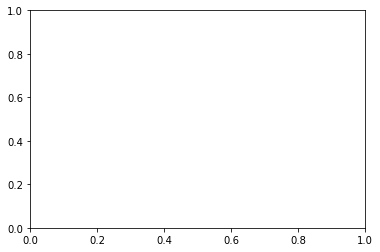

In [22]:
# visualisation of anomaly with cluster view
fig, ax = plt.subplots()
colors = {0:'blue', 1:'red'}
ax.scatter(df['principal_feature1'], df['principal_feature2'], c=df["anomaly21"].apply(lambda x: colors[x]))
plt.show()

KeyError: 'anomaly21'

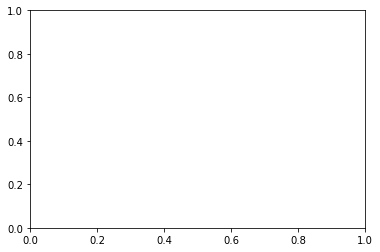

In [28]:
# visualisation of anomaly throughout time (viz 1)
fig, ax = plt.subplots()

a = df.loc[df['anomaly21'] == 1, ['time_epoch', 'value']] #anomaly

ax.plot(df['time_epoch'], df['value'], color='blue')
ax.scatter(a['time_epoch'],a['value'], color='red')
plt.show()

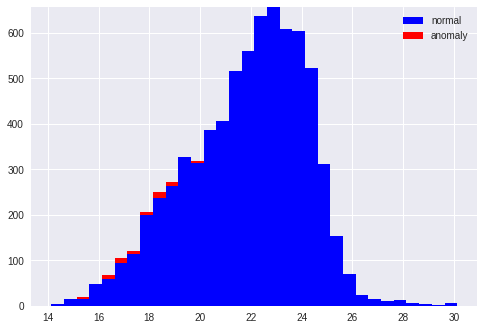

In [19]:
# visualisation of anomaly with temperature repartition (viz 2)
a = df.loc[df['anomaly21'] == 0, 'value']
b = df.loc[df['anomaly21'] == 1, 'value']

fig, axs = plt.subplots()
axs.hist([a,b], bins=32, stacked=True, color=['blue', 'red'], label=['normal', 'anomaly'])
plt.legend()
plt.show()

Cluster method detects the low temperature around the end of record as unusually low. It doesn't detect the highest temperature pic.
## 2.2 Categories + Gaussian
#### Use for contextual data and collective anomalies (unordered).  
We will separate data by (what we think of) important categories. Or we can separate data based on different cluster (method 2.3). Then we find outliers (gaussian repartition, unimodal) by categories independently.   

In [42]:
# creation of 4 differents data set based on categories defined before
df_class0 = df.loc[df['categories'] == 0, 'value']
df_class1 = df.loc[df['categories'] == 1, 'value']
df_class2 = df.loc[df['categories'] == 2, 'value']
df_class3 = df.loc[df['categories'] == 3, 'value']

<AxesSubplot:>

<AxesSubplot:>

<AxesSubplot:>

<AxesSubplot:>

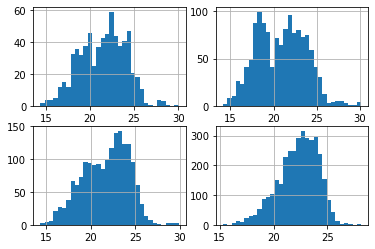

In [43]:
# plot the temperature repartition by categories
fig, axs = plt.subplots(2,2)
df_class0.hist(ax=axs[0,0],bins=32)
df_class1.hist(ax=axs[0,1],bins=32)
df_class2.hist(ax=axs[1,0],bins=32)
df_class3.hist(ax=axs[1,1],bins=32)

In [44]:
# apply ellipticEnvelope(gaussian distribution) at each categories
envelope =  EllipticEnvelope(contamination = outliers_fraction) 
X_train = df_class0.values.reshape(-1,1)
envelope.fit(X_train)
df_class0 = pd.DataFrame(df_class0)
df_class0['deviation'] = envelope.decision_function(X_train)
df_class0['anomaly'] = envelope.predict(X_train)

envelope =  EllipticEnvelope(contamination = outliers_fraction) 
X_train = df_class1.values.reshape(-1,1)
envelope.fit(X_train)
df_class1 = pd.DataFrame(df_class1)
df_class1['deviation'] = envelope.decision_function(X_train)
df_class1['anomaly'] = envelope.predict(X_train)

envelope =  EllipticEnvelope(contamination = outliers_fraction) 
X_train = df_class2.values.reshape(-1,1)
envelope.fit(X_train)
df_class2 = pd.DataFrame(df_class2)
df_class2['deviation'] = envelope.decision_function(X_train)
df_class2['anomaly'] = envelope.predict(X_train)

envelope =  EllipticEnvelope(contamination = outliers_fraction) 
X_train = df_class3.values.reshape(-1,1)
envelope.fit(X_train)
df_class3 = pd.DataFrame(df_class3)
df_class3['deviation'] = envelope.decision_function(X_train)
df_class3['anomaly'] = envelope.predict(X_train)

EllipticEnvelope(contamination=0.01)

EllipticEnvelope(contamination=0.01)

EllipticEnvelope(contamination=0.01)

EllipticEnvelope(contamination=0.01)

(array([[ 0.,  2.,  4.,  5., 12., 15., 12., 33., 36., 32., 38., 46., 25.,
         37., 43., 45., 59., 44., 38., 41., 47., 21., 18., 11.,  2.,  1.,
          0.,  4.,  2.,  0.,  0.,  0.],
        [ 2.,  4.,  4.,  5., 12., 15., 12., 33., 36., 32., 38., 46., 25.,
         37., 43., 45., 59., 44., 38., 41., 47., 21., 18., 11.,  2.,  1.,
          0.,  4.,  3.,  1.,  0.,  1.]]),
 array([14.35809618, 14.84820272, 15.33830926, 15.8284158 , 16.31852234,
        16.80862888, 17.29873542, 17.78884196, 18.27894851, 18.76905505,
        19.25916159, 19.74926813, 20.23937467, 20.72948121, 21.21958775,
        21.70969429, 22.19980083, 22.68990737, 23.18001392, 23.67012046,
        24.160227  , 24.65033354, 25.14044008, 25.63054662, 26.12065316,
        26.6107597 , 27.10086624, 27.59097278, 28.08107932, 28.57118587,
        29.06129241, 29.55139895, 30.04150549]),
 <a list of 2 BarContainer objects>)

(array([[ 2.,  9., 11., 27., 23., 41., 49., 88., 99., 88., 78., 41., 72.,
         64., 81., 96., 77., 80., 73., 75., 59., 41., 31., 13.,  3.,  4.,
          5.,  0.,  0.,  0.,  0.,  0.],
        [ 2.,  9., 11., 27., 23., 41., 49., 88., 99., 88., 78., 41., 72.,
         64., 81., 96., 77., 80., 73., 75., 59., 41., 31., 13.,  3.,  4.,
          5.,  5.,  3.,  1.,  1.,  4.]]),
 array([14.14355866, 14.64294767, 15.14233668, 15.64172569, 16.1411147 ,
        16.64050371, 17.13989273, 17.63928174, 18.13867075, 18.63805976,
        19.13744877, 19.63683778, 20.13622679, 20.6356158 , 21.13500481,
        21.63439382, 22.13378283, 22.63317184, 23.13256085, 23.63194987,
        24.13133888, 24.63072789, 25.1301169 , 25.62950591, 26.12889492,
        26.62828393, 27.12767294, 27.62706195, 28.12645096, 28.62583997,
        29.12522898, 29.62461799, 30.12400701]),
 <a list of 2 BarContainer objects>)

(array([[  0.,   0.,   2.,  21.,  27.,  26.,  38.,  66.,  61.,  72.,  95.,
          94.,  91.,  92.,  85.,  98., 116., 140., 143., 122., 123.,  95.,
          60.,  31.,  13.,   8.,   3.,   1.,   0.,   0.,   0.,   0.],
        [  3.,   4.,   6.,  21.,  27.,  26.,  38.,  66.,  61.,  72.,  95.,
          94.,  91.,  92.,  85.,  98., 116., 140., 143., 122., 123.,  95.,
          60.,  31.,  13.,   8.,   3.,   1.,   0.,   2.,   2.,   3.]]),
 array([14.36772539, 14.85112964, 15.33453388, 15.81793813, 16.30134238,
        16.78474663, 17.26815087, 17.75155512, 18.23495937, 18.71836362,
        19.20176786, 19.68517211, 20.16857636, 20.65198061, 21.13538485,
        21.6187891 , 22.10219335, 22.5855976 , 23.06900185, 23.55240609,
        24.03581034, 24.51921459, 25.00261884, 25.48602308, 25.96942733,
        26.45283158, 26.93623583, 27.41964007, 27.90304432, 28.38644857,
        28.86985282, 29.35325706, 29.83666131]),
 <a list of 2 BarContainer objects>)

(array([[  0.,   0.,   0.,   0.,   0.,  22.,  29.,  34.,  54.,  87.,  93.,
         105., 151., 138., 229., 248., 250., 293., 317., 291., 285., 295.,
         238., 155.,  82.,  43.,  13.,   4.,   6.,   3.,   1.,   0.],
        [  2.,   1.,   5.,  14.,  11.,  22.,  29.,  34.,  54.,  87.,  93.,
         105., 151., 138., 229., 248., 250., 293., 317., 291., 285., 295.,
         238., 155.,  82.,  43.,  13.,   4.,   6.,   3.,   1.,   3.]]),
 array([15.29794318, 15.69882842, 16.09971366, 16.5005989 , 16.90148414,
        17.30236938, 17.70325463, 18.10413987, 18.50502511, 18.90591035,
        19.30679559, 19.70768083, 20.10856607, 20.50945131, 20.91033656,
        21.3112218 , 21.71210704, 22.11299228, 22.51387752, 22.91476276,
        23.315648  , 23.71653325, 24.11741849, 24.51830373, 24.91918897,
        25.32007421, 25.72095945, 26.12184469, 26.52272993, 26.92361518,
        27.32450042, 27.72538566, 28.1262709 ]),
 <a list of 2 BarContainer objects>)

Text(0.5, 1.0, 'WeekEndNight')

Text(0.5, 1.0, 'WeekEndLight')

Text(0.5, 1.0, 'WeekDayNight')

Text(0.5, 1.0, 'WeekDayLight')

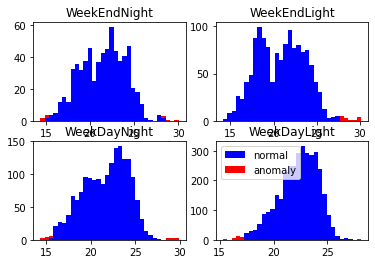

In [45]:
# plot the temperature repartition by categories with anomalies
a0 = df_class0.loc[df_class0['anomaly'] == 1, 'value']
b0 = df_class0.loc[df_class0['anomaly'] == -1, 'value']

a1 = df_class1.loc[df_class1['anomaly'] == 1, 'value']
b1 = df_class1.loc[df_class1['anomaly'] == -1, 'value']

a2 = df_class2.loc[df_class2['anomaly'] == 1, 'value']
b2 = df_class2.loc[df_class2['anomaly'] == -1, 'value']

a3 = df_class3.loc[df_class3['anomaly'] == 1, 'value']
b3 = df_class3.loc[df_class3['anomaly'] == -1, 'value']

fig, axs = plt.subplots(2,2)
axs[0,0].hist([a0,b0], bins=32, stacked=True, color=['blue', 'red'], label=['normal', 'anomaly'])
axs[0,1].hist([a1,b1], bins=32, stacked=True, color=['blue', 'red'], label=['normal', 'anomaly'])
axs[1,0].hist([a2,b2], bins=32, stacked=True, color=['blue', 'red'], label=['normal', 'anomaly'])
axs[1,1].hist([a3,b3], bins=32, stacked=True, color=['blue', 'red'], label=['normal', 'anomaly'])
axs[0,0].set_title("WeekEndNight")
axs[0,1].set_title("WeekEndLight")
axs[1,0].set_title("WeekDayNight")
axs[1,1].set_title("WeekDayLight")
plt.legend()
plt.show()

In [46]:
# add the data to the main 
df_class = pd.concat([df_class0, df_class1, df_class2, df_class3])
df['anomaly22'] = df_class['anomaly']
df['anomaly22'] = np.array(df['anomaly22'] == -1).astype(int) 

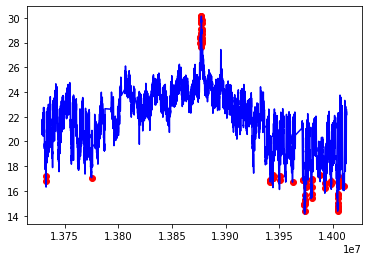

In [47]:
# visualisation of anomaly throughout time (viz 1)
fig, ax = plt.subplots()

a = df.loc[df['anomaly22'] == 1, ('time_epoch', 'value')] #anomaly

ax.plot(df['time_epoch'], df['value'], color='blue')
ax.scatter(a['time_epoch'],a['value'], color='red')
plt.show()

(array([[  2.,   9.,  16.,  45.,  60.,  86., 116., 207., 249., 272., 328.,
         319., 386., 406., 515., 559., 637., 657., 608., 603., 522., 312.,
         154.,  70.,  23.,  15.,  10.,   4.,   2.,   0.,   0.,   0.],
        [  5.,  16.,  20.,  49.,  67., 104., 121., 207., 249., 272., 328.,
         319., 386., 406., 515., 559., 637., 657., 608., 603., 522., 312.,
         154.,  70.,  23.,  15.,  10.,  12.,   7.,   5.,   2.,   7.]]),
 array([14.14355866, 14.64294767, 15.14233668, 15.64172569, 16.1411147 ,
        16.64050371, 17.13989273, 17.63928174, 18.13867075, 18.63805976,
        19.13744877, 19.63683778, 20.13622679, 20.6356158 , 21.13500481,
        21.63439382, 22.13378283, 22.63317184, 23.13256085, 23.63194987,
        24.13133888, 24.63072789, 25.1301169 , 25.62950591, 26.12889492,
        26.62828393, 27.12767294, 27.62706195, 28.12645096, 28.62583997,
        29.12522898, 29.62461799, 30.12400701]),
 <a list of 2 BarContainer objects>)

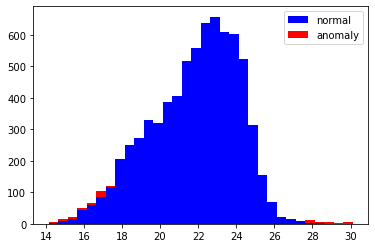

In [48]:
# visualisation of anomaly with temperature repartition (viz 2)
a = df.loc[df['anomaly22'] == 0, 'value']
b = df.loc[df['anomaly22'] == 1, 'value']

fig, axs = plt.subplots()
axs.hist([a,b], bins=32, stacked=True, color=['blue', 'red'], label=['normal', 'anomaly'])
plt.legend()
plt.show()

Good detections of extreme values and context separation add some precision to the detection.
## 2.3 Cluster+Gaussian
Similar to 2.2 solution but with cluster to separate data in different group.

## 2.4 Markov chains
#### Use for  sequential anomalies (ordered)
We need discretize the data points in define states for markov chain. We will just take 'value' to define state for this example and define 5 levels of value (very low, low, average, high, very high)/(VL, L, A, H, VH).
Markov chain will calculate the probability of sequence like (VL, L, L, A, A, L, A). If the probability is very weak we consider the sequence as an anomaly.

In [49]:
# definition of the different state
x1 = (df['value'] <=18).astype(int)
x2= ((df['value'] > 18) & (df['value']<=21)).astype(int)
x3 = ((df['value'] > 21) & (df['value']<=24)).astype(int)
x4 = ((df['value'] > 24) & (df['value']<=27)).astype(int)
x5 = (df['value'] >27).astype(int)
df_mm = x1 + 2*x2 + 3*x3 + 4*x4 + 5*x5

# getting the anomaly labels for our dataset (evaluating sequence of 5 values and anomaly = less than 20% probable)
# I USE pyemma NOT AVAILABLE IN KAGGLE KERNEL
#df_anomaly = markovAnomaly(df_mm, 5, 0.20)
#df_anomaly = pd.Series(df_anomaly)
#print(df_anomaly.value_counts())

In [50]:
"""
# add the data to the main 
df['anomaly24'] = df_anomaly

# visualisation of anomaly throughout time (viz 1)
fig, ax = plt.subplots()

a = df.loc[df['anomaly24'] == 1, ('time_epoch', 'value')] #anomaly

ax.plot(df['time_epoch'], df['value'], color='blue')
ax.scatter(a['time_epoch'],a['value'], color='red')
plt.show()
"""

"\n# add the data to the main \ndf['anomaly24'] = df_anomaly\n\n# visualisation of anomaly throughout time (viz 1)\nfig, ax = plt.subplots()\n\na = df.loc[df['anomaly24'] == 1, ('time_epoch', 'value')] #anomaly\n\nax.plot(df['time_epoch'], df['value'], color='blue')\nax.scatter(a['time_epoch'],a['value'], color='red')\nplt.show()\n"

In [51]:
"""
# visualisation of anomaly with temperature repartition (viz 2)
a = df.loc[df['anomaly24'] == 0, 'value']
b = df.loc[df['anomaly24'] == 1, 'value']

fig, axs = plt.subplots()
axs.hist([a,b], bins=32, stacked=True, color=['blue', 'red'])
plt.legend()
plt.show()
"""

"\n# visualisation of anomaly with temperature repartition (viz 2)\na = df.loc[df['anomaly24'] == 0, 'value']\nb = df.loc[df['anomaly24'] == 1, 'value']\n\nfig, axs = plt.subplots()\naxs.hist([a,b], bins=32, stacked=True, color=['blue', 'red'])\nplt.legend()\nplt.show()\n"

Detect unusual sequence but not extreme value. More difficult to evaluate the relevance on this example. The sequence size (5) should be match with some interesting cycle.
## 2.5 Isolation Forest
#### Use for collective anomalies (unordered).
Simple, works well with different data repartition and efficient with high dimention data.

In [52]:
# Take useful feature and standardize them 
data = df[['value', 'hours', 'daylight', 'DayOfTheWeek', 'WeekDay']]
min_max_scaler = preprocessing.StandardScaler()
np_scaled = min_max_scaler.fit_transform(data)
data = pd.DataFrame(np_scaled)
# train isolation forest 
model =  IsolationForest(contamination = outliers_fraction)
model.fit(data)
# add the data to the main  
df['anomaly25'] = pd.Series(model.predict(data))
df['anomaly25'] = df['anomaly25'].map( {1: 0, -1: 1} )
print(df['anomaly25'].value_counts())

IsolationForest(contamination=0.01)

0    7194
1      73
Name: anomaly25, dtype: int64


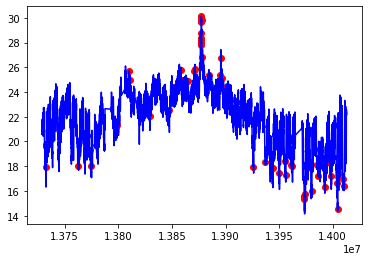

In [53]:
# visualisation of anomaly throughout time (viz 1)
fig, ax = plt.subplots()

a = df.loc[df['anomaly25'] == 1, ['time_epoch', 'value']] #anomaly

ax.plot(df['time_epoch'], df['value'], color='blue')
ax.scatter(a['time_epoch'],a['value'], color='red')
plt.show()

(array([[  4.,  16.,  17.,  47.,  64., 103., 116., 199., 244., 270., 327.,
         318., 386., 406., 514., 557., 633., 657., 606., 602., 515., 308.,
         152.,  66.,  23.,  13.,  10.,   9.,   4.,   4.,   2.,   2.],
        [  5.,  16.,  20.,  49.,  67., 104., 121., 207., 249., 272., 328.,
         319., 386., 406., 515., 559., 637., 657., 608., 603., 522., 312.,
         154.,  70.,  23.,  15.,  10.,  12.,   7.,   5.,   2.,   7.]]),
 array([14.14355866, 14.64294767, 15.14233668, 15.64172569, 16.1411147 ,
        16.64050371, 17.13989273, 17.63928174, 18.13867075, 18.63805976,
        19.13744877, 19.63683778, 20.13622679, 20.6356158 , 21.13500481,
        21.63439382, 22.13378283, 22.63317184, 23.13256085, 23.63194987,
        24.13133888, 24.63072789, 25.1301169 , 25.62950591, 26.12889492,
        26.62828393, 27.12767294, 27.62706195, 28.12645096, 28.62583997,
        29.12522898, 29.62461799, 30.12400701]),
 <a list of 2 BarContainer objects>)

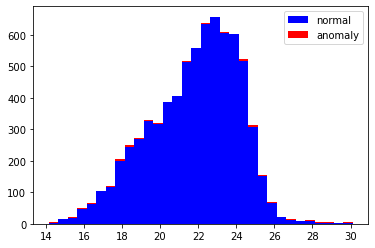

In [54]:
# visualisation of anomaly with temperature repartition (viz 2)
a = df.loc[df['anomaly25'] == 0, 'value']
b = df.loc[df['anomaly25'] == 1, 'value']

fig, axs = plt.subplots()
axs.hist([a,b], bins=32, stacked=True, color=['blue', 'red'], label = ['normal', 'anomaly'])
plt.legend()
plt.show()

## 2.6 One class SVM
#### Use for collective anomalies (unordered).
Good for novelty detection (no anomalies in the train set). This algorithm performs well for multimodal data.

In [55]:
# Take useful feature and standardize them 
data = df[['value', 'hours', 'daylight', 'DayOfTheWeek', 'WeekDay']]
min_max_scaler = preprocessing.StandardScaler()
np_scaled = min_max_scaler.fit_transform(data)
# train one class SVM 
model =  OneClassSVM(nu=0.95 * outliers_fraction) #nu=0.95 * outliers_fraction  + 0.05
data = pd.DataFrame(np_scaled)
model.fit(data)
# add the data to the main  
df['anomaly26'] = pd.Series(model.predict(data))
df['anomaly26'] = df['anomaly26'].map( {1: 0, -1: 1} )
print(df['anomaly26'].value_counts())

OneClassSVM(nu=0.0095)

0    7198
1      69
Name: anomaly26, dtype: int64


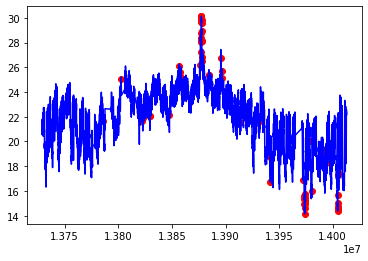

In [56]:
# visualisation of anomaly throughout time (viz 1)
fig, ax = plt.subplots()

a = df.loc[df['anomaly26'] == 1, ['time_epoch', 'value']] #anomaly

ax.plot(df['time_epoch'], df['value'], color='blue')
ax.scatter(a['time_epoch'],a['value'], color='red')
plt.show()

(array([[  2.,   9.,  15.,  46.,  67., 102., 119., 207., 248., 270., 326.,
         318., 386., 406., 514., 551., 634., 657., 608., 603., 522., 310.,
         151.,  67.,  21.,  13.,   9.,   9.,   4.,   3.,   1.,   0.],
        [  5.,  16.,  20.,  49.,  67., 104., 121., 207., 249., 272., 328.,
         319., 386., 406., 515., 559., 637., 657., 608., 603., 522., 312.,
         154.,  70.,  23.,  15.,  10.,  12.,   7.,   5.,   2.,   7.]]),
 array([14.14355866, 14.64294767, 15.14233668, 15.64172569, 16.1411147 ,
        16.64050371, 17.13989273, 17.63928174, 18.13867075, 18.63805976,
        19.13744877, 19.63683778, 20.13622679, 20.6356158 , 21.13500481,
        21.63439382, 22.13378283, 22.63317184, 23.13256085, 23.63194987,
        24.13133888, 24.63072789, 25.1301169 , 25.62950591, 26.12889492,
        26.62828393, 27.12767294, 27.62706195, 28.12645096, 28.62583997,
        29.12522898, 29.62461799, 30.12400701]),
 <a list of 2 BarContainer objects>)

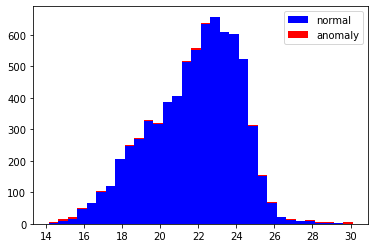

In [57]:
# visualisation of anomaly with temperature repartition (viz 2)
a = df.loc[df['anomaly26'] == 0, 'value']
b = df.loc[df['anomaly26'] == 1, 'value']

fig, axs = plt.subplots()
axs.hist([a,b], bins=32, stacked=True, color=['blue', 'red'], label=['normal', 'anomaly'])
plt.legend()
plt.show()

Give result similar to isolation forest but find some anomalies in average values. Difficult to know if it's relevant.

# End